In [1]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv("/content/drive/MyDrive/udemy_time_series/energydata_complete.csv")

In [16]:
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").resample("H").mean()
df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,55.000000,35.000000,19.890000,46.502778,19.200000,44.626528,19.790000,44.897778,18.932778,45.738750,17.166667,55.116667,6.586667,84.260000,17.177778,41.400000,18.150000,48.710556,17.016667,45.446667,6.308333,733.750000,92.000000,6.166667,53.416667,5.050000,26.823044,26.823044
2016-01-11 18:00:00,176.666667,51.666667,19.897778,45.879028,19.268889,44.438889,19.770000,44.863333,18.908333,46.066667,17.111111,54.977778,6.180000,87.204444,17.229583,42.046806,18.094444,48.597222,16.981667,45.290000,5.941667,734.266667,91.583333,5.416667,40.000000,4.658333,22.324206,22.324206
2016-01-11 19:00:00,173.333333,25.000000,20.495556,52.805556,19.925556,46.061667,20.052222,47.227361,18.969444,47.815556,17.136111,55.869861,5.857361,88.131389,17.850000,45.017778,18.156111,49.213333,16.902222,45.311389,6.000000,734.791667,89.750000,6.000000,40.000000,4.391667,33.734932,33.734932
2016-01-11 20:00:00,125.000000,35.000000,20.961111,48.453333,20.251111,45.632639,20.213889,47.268889,19.190833,49.227917,17.615556,74.027778,5.469444,86.933889,17.632222,42.920000,18.773333,50.195556,16.890000,45.118889,6.000000,735.283333,87.583333,6.000000,40.000000,4.016667,25.679642,25.679642
2016-01-11 21:00:00,103.333333,23.333333,21.311667,45.768333,20.587778,44.961111,20.373333,46.164444,19.425556,47.918889,18.427222,69.037778,5.578889,86.129444,17.863611,43.618333,19.153333,49.542222,16.890000,44.807778,5.833333,735.566667,87.416667,6.000000,40.000000,3.816667,18.826274,18.826274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 14:00:00,101.666667,1.666667,25.544444,46.638889,26.421369,41.205054,28.397778,41.160000,24.666667,45.883889,22.890000,53.052222,25.567222,1.000000,23.968048,43.342905,23.848333,49.253056,23.100000,46.594444,21.916667,755.800000,59.000000,2.000000,21.583333,13.475000,27.553946,27.553946
2016-05-27 15:00:00,76.666667,0.000000,25.500000,45.677639,26.154762,41.041238,28.240000,40.306667,24.694444,45.270000,23.007500,52.368611,26.279444,1.000000,24.045238,43.189905,23.926667,48.883333,23.138889,46.590000,22.216667,755.675000,57.333333,2.000000,21.833333,13.258333,25.429025,25.429025
2016-05-27 16:00:00,135.000000,0.000000,25.487778,46.250000,26.000000,41.736190,27.953333,40.607778,24.700000,45.476667,23.150000,52.094444,26.138889,1.000000,24.353333,44.330905,24.271444,50.785667,23.193333,46.645381,22.883333,755.375000,55.000000,2.416667,22.583333,13.283333,23.229344,23.229344


In [17]:
df = df.loc["2016-01-12":"2016-05-25", :]
df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 00:00:00,141.666667,16.666667,21.266111,44.960556,20.637222,44.018333,20.144444,45.542222,20.514444,47.112778,19.155556,50.396111,5.463333,89.107222,17.755000,44.590000,19.396667,51.695556,16.890000,45.875000,5.216667,737.150000,92.000000,6.000000,29.500000,4.016667,26.296718,26.296718
2016-01-12 01:00:00,168.333333,8.333333,20.963611,45.613194,20.333333,44.273333,20.133333,45.540000,21.505556,46.946667,18.969444,50.076111,4.810000,91.045000,17.790000,45.728611,19.280000,53.247778,16.890000,46.307778,5.141667,737.833333,92.000000,5.583333,40.000000,3.941667,28.723073,28.723073
2016-01-12 02:00:00,45.000000,0.000000,20.696667,46.197778,20.066667,44.503333,20.170833,45.454167,21.143056,45.905556,18.813333,50.122083,4.250556,92.690000,17.845556,46.018889,19.192639,54.868194,16.975556,47.263333,5.033333,738.550000,92.000000,4.583333,40.000000,3.833333,17.282387,17.282387
2016-01-12 03:00:00,35.000000,0.000000,20.462222,46.240000,19.792222,44.560000,20.230000,45.427778,20.416667,46.108889,18.655556,50.050000,4.010833,93.737500,17.878889,46.110000,19.200000,54.930000,17.022222,48.083333,4.841667,739.191667,92.416667,4.833333,40.000000,3.683333,24.223558,24.223558
2016-01-12 04:00:00,45.000000,0.000000,20.229444,46.483611,19.600000,44.651111,20.285000,45.525000,19.951111,46.396667,18.522222,50.000000,4.696667,94.728889,17.890000,45.788333,19.100000,54.476667,17.055556,48.827500,4.941667,739.725000,92.166667,5.583333,40.000000,3.716667,28.191145,28.191145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-25 19:00:00,118.333333,0.000000,24.447403,37.297468,23.623734,34.920130,24.849351,36.625325,24.237403,38.034416,21.384156,50.362256,18.897511,3.974675,23.378896,35.245455,24.500325,40.741071,22.100000,38.101840,16.316667,756.100000,55.833333,1.583333,33.583333,7.366667,32.968599,32.968599
2016-05-25 20:00:00,190.000000,1.666667,24.377273,37.694091,23.522045,35.613636,24.861818,36.859091,24.167273,38.213636,21.376364,50.381932,18.285303,7.940909,23.364091,35.572727,24.434091,41.002500,22.100000,38.606515,15.741667,756.183333,59.916667,1.416667,34.166667,7.933333,34.942931,34.942931
2016-05-25 21:00:00,56.666667,3.333333,24.307143,38.090714,23.420357,36.307143,24.874286,37.092857,24.097143,38.392857,21.368571,50.401607,17.673095,11.907143,23.349286,35.900000,24.367857,41.263929,22.100000,39.111190,14.266667,756.425000,68.583333,1.583333,31.833333,8.566667,33.016733,33.016733


In [18]:
cols = ["Appliances", "RH_out"]
df = df[cols]
df

,Appliances,RH_out
date,,
2016-01-12 00:00:00,141.666667,92.000000
2016-01-12 01:00:00,168.333333,92.000000
2016-01-12 02:00:00,45.000000,92.000000
2016-01-12 03:00:00,35.000000,92.416667
2016-01-12 04:00:00,45.000000,92.166667
...,...,...
2016-05-25 19:00:00,118.333333,55.833333
2016-05-25 20:00:00,190.000000,59.916667
2016-05-25 21:00:00,56.666667,68.583333


In [19]:
rh_min = df["RH_out"].min()
rh_max = df["RH_out"].max()

ap_min = df["Appliances"].min()
ap_max = df["Appliances"].max()

In [20]:
print(rh_min, rh_max, ap_min, ap_max)

25.25 100.0 28.333333333333332 608.3333333333334


In [21]:
df["RH_out_scaled"] = (df["RH_out"] - rh_min) / (rh_max - rh_min)
df["Appliances_scaled"] = (df["Appliances"] - ap_min) / (ap_max - ap_min)

df = df[["RH_out_scaled", "Appliances_scaled"]]
df

<ipython-input-21-34b69b300394>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RH_out_scaled"] = (df["RH_out"] - rh_min) / (rh_max - rh_min)
<ipython-input-21-34b69b300394>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Appliances_scaled"] = (df["Appliances"] - ap_min) / (ap_max - ap_min)


,RH_out_scaled,Appliances_scaled
date,,
2016-01-12 00:00:00,0.892977,0.195402
2016-01-12 01:00:00,0.892977,0.241379
2016-01-12 02:00:00,0.892977,0.028736
2016-01-12 03:00:00,0.898551,0.011494
2016-01-12 04:00:00,0.895206,0.028736
...,...,...
2016-05-25 19:00:00,0.409142,0.155172
2016-05-25 20:00:00,0.463768,0.278736
2016-05-25 21:00:00,0.579710,0.048851


In [26]:
df["Appliances_scaled"].min()

0.0

In [27]:
df_train = df.loc[:"2016-04-30", :]
df_test = df.loc["2016-05-01": , :]

In [28]:
df_train

,RH_out_scaled,Appliances_scaled
date,,
2016-01-12 00:00:00,0.892977,0.195402
2016-01-12 01:00:00,0.892977,0.241379
2016-01-12 02:00:00,0.892977,0.028736
2016-01-12 03:00:00,0.898551,0.011494
2016-01-12 04:00:00,0.895206,0.028736
...,...,...
2016-04-30 19:00:00,0.558528,0.054598
2016-04-30 20:00:00,0.569677,0.074713
2016-04-30 21:00:00,0.618729,0.071839


In [29]:
df_test

,RH_out_scaled,Appliances_scaled
date,,
2016-05-01 00:00:00,0.823857,0.040230
2016-05-01 01:00:00,0.850613,0.045977
2016-05-01 02:00:00,0.877369,0.034483
2016-05-01 03:00:00,0.898551,0.022989
2016-05-01 04:00:00,0.923077,0.043103
...,...,...
2016-05-25 19:00:00,0.409142,0.155172
2016-05-25 20:00:00,0.463768,0.278736
2016-05-25 21:00:00,0.579710,0.048851


## 学習用データ作成
- n_steps_in : 7*24
- n_steps_out : 24

各行に対して24行飛ばしでforループを回し、その行からn_steps_in個のデータを説明変数X、さらにn_steps_out個データを目的変数yとして、numpy arrayで出力する

In [30]:
def make_sequences(sequences, n_steps_in, n_steps_out):
  X = []
  y = []

  for i in range(0, len(sequences), 24):
    end_num = i + n_steps_in + 1 # 学習用の最後
    out_end_num = end_num + n_steps_out -1

    if out_end_num > len(sequences):
      break
    
    x_seq = sequences[i:end_num-1, :]
    y_seq = sequences[end_num-1:out_end_num, -1]

    X.append(x_seq)
    y.append(y_seq)

  return np.array(X), np.array(y)

In [31]:
dataset_train = df_train.dropna().values
dataset_test = df_test.dropna().values
n_steps_in = 24*7
n_steps_out = 24

X_train, y_train = make_sequences(dataset_train, n_steps_in, n_steps_out)
X_test, y_test = make_sequences(dataset_test, n_steps_in, n_steps_out)

In [32]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(103, 168, 2)
(103, 24)
(18, 168, 2)
(18, 24)


In [43]:
n_features = X_train.shape[2]
n_timesteps = X_train.shape[1]
n_outputs = y_train.shape[1]

## CNN

In [44]:
model = Sequential()
model.add(Conv1D(filters = 32, kernel_size = 2, activation = 'relu', input_shape = (n_steps_in, n_features)))
model.add(Conv1D(filters = 32, kernel_size = 2, activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer=Adam(learning_rate = 0.01))

In [46]:
epoch = 10
val_split_rate = 0.2
batch_size = 32

history = model.fit(
    X_train
    , y_train
    , epochs = epoch
    , batch_size = batch_size
    , validation_split = val_split_rate
    , verbose = 1
)

print(model.summary)

Epoch 1/10
3/3 [==============================] - 1s 128ms/step - loss: 0.4006 - val_loss: 0.0394
Epoch 2/10
3/3 [==============================] - 0s 30ms/step - loss: 0.0389 - val_loss: 0.0306
Epoch 3/10
3/3 [==============================] - 0s 37ms/step - loss: 0.0330 - val_loss: 0.0275
Epoch 4/10
3/3 [==============================] - 0s 32ms/step - loss: 0.0291 - val_loss: 0.0222
Epoch 5/10
3/3 [==============================] - 0s 30ms/step - loss: 0.0234 - val_loss: 0.0174
Epoch 6/10
3/3 [==============================] - 0s 30ms/step - loss: 0.0184 - val_loss: 0.0158
Epoch 7/10
3/3 [==============================] - 0s 29ms/step - loss: 0.0174 - val_loss: 0.0169
Epoch 8/10
3/3 [==============================] - 0s 30ms/step - loss: 0.0176 - val_loss: 0.0169
Epoch 9/10
3/3 [==============================] - 0s 36ms/step - loss: 0.0166 - val_loss: 0.0159
Epoch 10/10
3/3 [==============================] - 0s 30ms/step - loss: 0.0158 - val_loss: 0.0155
<bound method Model.summary 

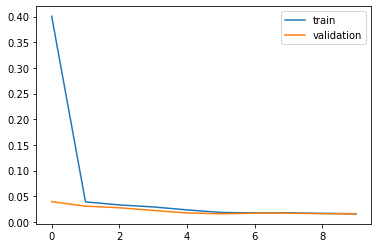

In [47]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()

In [49]:
pred = model.predict(X_test)
pred_ = pred.ravel().tolist()

1/1 [==============================] - 0s 39ms/step


In [50]:
pred_

[0.019466888159513474,
 -0.0063466038554906845,
 0.025995953008532524,
 0.0005727000534534454,
 -0.0006416141986846924,
 0.02912941202521324,
 0.031203873455524445,
 0.05513349920511246,
 0.08603072911500931,
 0.13956210017204285,
 0.16525374352931976,
 0.19346007704734802,
 0.18463647365570068,
 0.20050305128097534,
 0.1382105052471161,
 0.15233536064624786,
 0.17876923084259033,
 0.15654070675373077,
 0.31217652559280396,
 0.2216571569442749,
 0.19483621418476105,
 0.10444676876068115,
 0.04387970641255379,
 0.06180645525455475,
 0.019470350816845894,
 -0.006321988999843597,
 0.026037512347102165,
 0.0005842037498950958,
 -0.0006552934646606445,
 0.02907111868262291,
 0.03110993653535843,
 0.05510687455534935,
 0.08595237135887146,
 0.13948661088943481,
 0.16532094776630402,
 0.19346049427986145,
 0.18466824293136597,
 0.20047053694725037,
 0.13815303146839142,
 0.15238624811172485,
 0.17866826057434082,
 0.15642574429512024,
 0.3121532201766968,
 0.22161981463432312,
 0.194889768958

In [51]:
y_test_ = y_test.ravel().tolist()

In [52]:
result_df = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_)], axis=1))
result_df.columns = ["y_scaled", "pred_scaled"]
result_df

,y_scaled,pred_scaled
0,0.051724,0.019467
1,0.040230,-0.006347
2,0.045977,0.025996
3,0.048851,0.000573
4,0.037356,-0.000642
...,...,...
427,0.155172,0.221650
428,0.278736,0.194924
429,0.048851,0.104406
430,0.043103,0.043905


In [53]:
result_df["y_original"] = result_df["y_scaled"] * (ap_max-ap_min) + ap_min
result_df["pred_original"] = result_df["pred_scaled"] * (ap_max-ap_min) + ap_min
result_df

,y_scaled,pred_scaled,y_original,pred_original
0,0.051724,0.019467,58.333333,39.624128
1,0.040230,-0.006347,51.666667,24.652303
2,0.045977,0.025996,55.000000,43.410986
3,0.048851,0.000573,56.666667,28.665499
4,0.037356,-0.000642,50.000000,27.961197
...,...,...,...,...
427,0.155172,0.221650,118.333333,156.890336
428,0.278736,0.194924,190.000000,141.389087
429,0.048851,0.104406,56.666667,88.888605
430,0.043103,0.043905,53.333333,53.798124


<Axes: >

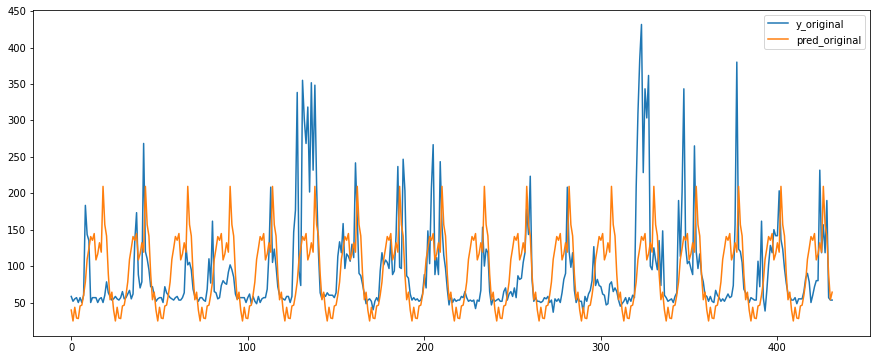

In [54]:
result_df[["y_original", "pred_original"]].plot(figsize=(15,6))

In [55]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(result_df["y_original"], result_df["pred_original"]))
print("RMSE:{:.2f}".format(rmse))

RMSE:63.41


## LSTM

In [56]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs = 10, verbose=1)

Epoch 1/10
4/4 [==============================] - 2s 112ms/step - loss: 0.0341
Epoch 2/10
4/4 [==============================] - 0s 116ms/step - loss: 0.0288
Epoch 3/10
4/4 [==============================] - 0s 114ms/step - loss: 0.0244
Epoch 4/10
4/4 [==============================] - 0s 115ms/step - loss: 0.0206
Epoch 5/10
4/4 [==============================] - 0s 111ms/step - loss: 0.0179
Epoch 6/10
4/4 [==============================] - 0s 109ms/step - loss: 0.0167
Epoch 7/10
4/4 [==============================] - 0s 110ms/step - loss: 0.0157
Epoch 8/10
4/4 [==============================] - 0s 112ms/step - loss: 0.0155
Epoch 9/10
4/4 [==============================] - 0s 116ms/step - loss: 0.0156
Epoch 10/10
4/4 [==============================] - 0s 109ms/step - loss: 0.0155


In [57]:
pred = model.predict(X_test)
pred_ = pred.ravel().tolist()
y_test_ = y_test.ravel().tolist()

1/1 [==============================] - 0s 379ms/step


In [58]:
result_df = pd.DataFrame(data=pd.concat([pd.Series(y_test_), pd.Series(pred_)], axis=1))
result_df.columns = ["y_scaled", "pred_scaled"]
result_df["y_original"] = result_df["y_scaled"] * (ap_max - ap_min) + ap_min
result_df["pred_original"] = result_df["pred_scaled"] * (ap_max - ap_min) + ap_min
result_df

,y_scaled,pred_scaled,y_original,pred_original
0,0.051724,0.019711,58.333333,39.765866
1,0.040230,0.038848,51.666667,50.865096
2,0.045977,0.024559,55.000000,42.577309
3,0.048851,0.037523,56.666667,50.096951
4,0.037356,0.030143,50.000000,45.816375
...,...,...,...,...
427,0.155172,0.187533,118.333333,137.102347
428,0.278736,0.171566,190.000000,127.841584
429,0.048851,0.101874,56.666667,87.420198
430,0.043103,0.060258,53.333333,63.282710


<Axes: >

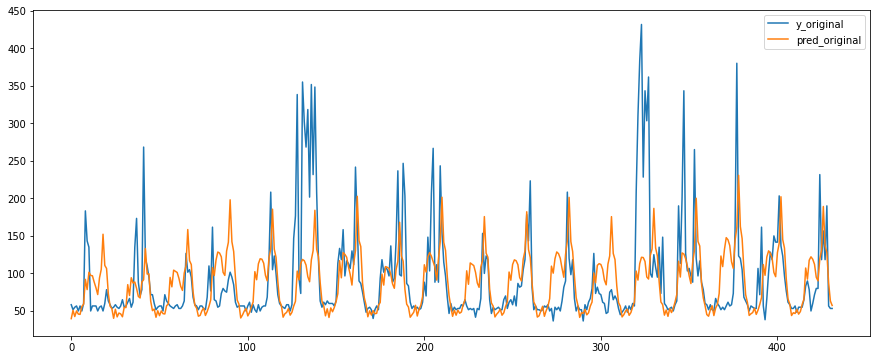

In [59]:
result_df[["y_original", "pred_original"]].plot(figsize=(15, 6))

In [60]:
rmse = np.sqrt(mean_squared_error(result_df["y_original"], result_df["pred_original"]))
print("RMSE:{:.2f}".format(rmse))

RMSE:58.80
